In [1]:
import debugpy
debugpy.configure(subProcess=False)

In [2]:
import os
import sys
from pathlib import Path
# Add parent directory to path (most common use case)
cwd = Path(os.getcwd())
if cwd.name == 'notebooks':
    sys.path.append(os.path.abspath('..'))

In [3]:
if cwd.name == 'notebooks':
    os.chdir('..')

In [4]:
import math
from dotenv import load_dotenv

from typing import Tuple
from itertools import zip_longest

import orjson
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import expon, weibull_min, lognorm
from scipy.optimize import minimize

import warnings

# Visualisation
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import seaborn as sns

from pydantic import BaseModel, Field, ConfigDict

from tqdm import tqdm

In [5]:
# autoreload
%load_ext autoreload
%autoreload 2

In [6]:
# Load environment variables
load_dotenv() 
# Remove warnings
warnings.filterwarnings("ignore") 


# Trying to determine optimal timing to look back per correlation type

Currently, when identifying correlations with a water anomaly, Marvin uses a fixed time window of 1h for poultry and 2h for pigs and tries to identify factors that are possibly correlated with the anomaly. There is now the ability to determine individual look-back windows per type of correlation. This notebook tries to assist in the determination of the optimal lookup-back time for Marvin per correlation (type).

**Dataset:**  
The dataset we use for the analysis has anomalies (per farm and shed) and their correlations. That is for each anomaly, we have as many entries as correlating factors Marvin has identified in the lookback window. 

**Hypothesis:**  
Assuming that the correlating factor "causes" the anomaly, it stands to reason to assume that of the correlating factor is "present" during a time, a number of anomalies will be caused with this specific correlating factor. 

**Sub-hypothesis 1:**
If we measure the time difference between an anomaly and all possible correlation factors, we should how frequent another anomaly with that correlating factor occurs in the past.

**Sub-hypothesis 2:**
If we measure the time difference for all correlating factors of an anomaly, we would see how far back the same correlating factor occurs in other anomalies.

**Limitations:**
- The animal type is not provided

In [7]:
PROCESS_BY_CATEGORY = True

In [8]:
SRCDIR = Path("/mnt/c/Users/heine/Downloads/rainfall")

In [9]:
files  = [f for f in SRCDIR.iterdir() if f.suffix == '.json']
df = pd.DataFrame() 
for f in tqdm(files, desc='Opening files'):
    with open(f, 'r') as infile:
        data = orjson.loads(infile.read())
        t_df = pd.json_normalize(data)
        t_df['LocalTime'] = pd.to_datetime(t_df['LocalTime']) # type:ignore
        t_df = t_df[['AnomalyId', 'LocalTime', 'FarmId', 'FarmName', 'ShedId', 'ShedName','Correlation','Category']]
        df = pd.concat([df, t_df], ignore_index=True)
df = df.sort_values(by='LocalTime')
df = df.reset_index(drop=True)

Opening files:   0%|          | 0/254 [00:00<?, ?it/s]

Opening files: 100%|██████████| 254/254 [00:03<00:00, 66.36it/s]


In [ ]:
df['Correlation'] = [corr.strip() for corr in df['Correlation']]
correlations = df['Correlation'].sort_values().unique()
categories = df['Category'].unique()
print(f"Found {len(correlations)} unique correlations and {len(categories)} unique categories.")

Found 29 unique correlations and 2 unique categories.


In [11]:
def order_correlations_by_pairs(correlations: list|np.ndarray) -> Tuple[int, list]:

    pairs = []
    singles = []

    special_pairs = [('Sunset','Sunrise'),('Lights On', 'Lights Off')]

    for correlation in correlations:
        if correlation.endswith('Increased'):
            cat_name = correlation.split('Increased')[0]
            if f"{cat_name}Decreased" in correlations:
                pairs.append(correlation)
        elif correlation.endswith('Decreased'):
            cat_name = correlation.split('Decreased')[0]
            if f"{cat_name}Increased" in correlations:
                pairs.append(correlation)
        elif any([correlation in pair for pair in special_pairs]):
            for pair in special_pairs:
                if correlation in pair:
                    other = pair[1] if correlation == pair[0] else pair[0]
                    break
            if other in correlations:
                pairs.append(correlation)
            else:
                singles.append(correlation)
        else:
            singles.append(correlation)
    
    pairs.sort() # automatic ordering
    singles.sort()

    return len(pairs+singles), pairs + singles

def order_correlations_by_category(correlations: list|np.ndarray, df:pd.DataFrame) -> Tuple[int, list]:

    pairs = []
    singles = []
    categories = df['Category'].unique()
    assert len(categories)==2

    for correlation in correlations:
            if len(df[df['Correlation']==correlation]['Category'].unique()) == 2:
                 pairs.append(correlation)
            else:
                singles.append(correlation)
    
    pairs.sort() # automatic ordering
    singles.sort()

    return len(pairs)*2+len(singles),pairs + singles


if PROCESS_BY_CATEGORY:
    number_of_plots, correlations_ordered = order_correlations_by_category(correlations=correlations, df=df)
else:
    number_of_plots, correlations_ordered = order_correlations_by_pairs(correlations=correlations)

In [ ]:
farmids = df['FarmId'].unique()
shedids = df['ShedId'].unique()
print(f"Found {len(farmids)} farms {len(shedids)} sheds.")

Found 33 farms 157 sheds.


In [13]:
start_of_dataset = df['LocalTime'].min()
max_lookback_length = 4 # hours
earliest_time = start_of_dataset + pd.Timedelta(hours=max_lookback_length)

In [ ]:
anomalyids = df['AnomalyId'].unique()
print(f"Found {len(anomalyids)} unique anomalies")

Found 6789 unique anomalies


In [ ]:
# Find all unique anomalies for each shed at least 2h after earliest_time
anomalies = df.groupby(by=['ShedId', 'AnomalyId', 'Category']).agg({'LocalTime':'min'}).reset_index()
anomalies = anomalies[anomalies['LocalTime'] > earliest_time]
print(f"Found {len(anomalies)} unique anomalies after {earliest_time}.")


Found 6701 unique anomalies after 2025-08-26 09:30:00.


In [16]:
anomalies

,ShedId,AnomalyId,Category,LocalTime
0,004d0cb2-b745-43f0-a028-39ac7ffcd1f3,097f8e36-58aa-48d3-b288-31065149b878,Increased Water,2025-09-01 13:15:00
1,004d0cb2-b745-43f0-a028-39ac7ffcd1f3,0d941112-93ad-477c-9282-a73d40478e00,Decreased Water,2025-09-01 11:05:00
2,004d0cb2-b745-43f0-a028-39ac7ffcd1f3,341bbc5b-1746-4740-a4f1-b93c231c327e,Increased Water,2025-09-01 13:20:00
4,004d0cb2-b745-43f0-a028-39ac7ffcd1f3,4a70becd-84dc-4fac-9317-a6e0328d2196,Increased Water,2025-08-28 19:15:00
5,004d0cb2-b745-43f0-a028-39ac7ffcd1f3,4d04bd11-c733-4c35-adf9-45f63362ed31,Increased Water,2025-09-01 15:00:00
...,...,...,...,...
6784,fd5b7bd5-fec5-4f73-a1e6-707c82f7e2ac,c4fe9e86-16a6-45a8-bd13-2f2e48a2881d,Increased Water,2025-09-11 19:50:00
6785,fd5b7bd5-fec5-4f73-a1e6-707c82f7e2ac,d9944ad3-cc53-4c3c-9d1d-24d985498d9b,Decreased Water,2025-09-11 14:20:00
6786,fd5b7bd5-fec5-4f73-a1e6-707c82f7e2ac,e43ff753-1a96-4e07-b818-5ec1f74ea465,Decreased Water,2025-09-11 15:35:00
6787,fd5b7bd5-fec5-4f73-a1e6-707c82f7e2ac,ed421a70-441a-465a-ad96-383d0a5597c7,Decreased Water,2025-09-11 19:45:00


In [17]:
# Now categorize delays into 15-min intervals
interval_labels = [f"{i*15}-{(i+1)*15}min" for i in range(int(max_lookback_length * 60 / 15))]

## Utility functions

In [18]:
from typing import Any
from pydantic import BaseModel, Field, ConfigDict

class Result(BaseModel):
    lambda_: float = Field(..., description="Mixture weight parameter")
    params1: list[float] = Field(..., description="Parameters for first distribution")
    params2: list[float] = Field(..., description="Parameters for second distribution")
    dist1: str = Field(..., description="Type of first distribution")
    dist2: str = Field(..., description="Type of second distribution")
    nll: float = Field(..., description="Negative log-likelihood of the fit")
    aic: float = Field(..., description="Akaike Information Criterion")
    bic: float = Field(..., description="Bayesian Information Criterion")
    n: int = Field(..., description="Number of data points")

    model_config = ConfigDict(arbitrary_types_allowed=True)


In [ ]:
"""
Ultra-simple mixture distribution fitting
Minimal dependencies, straightforward code
"""

def fit_mixture_simple(data, dist1='expon', dist2='weibull_min'):
    """
    Fit a two-component mixture distribution
    
    Parameters
    ----------
    data : array
        Your observations (e.g., time delays)
    dist1 : str
        Component 1: 'expon', 'weibull_min', or 'lognorm'
    dist2 : str
        Component 2: 'expon', 'weibull_min', or 'lognorm'
    
    Returns
    -------
    dict with fitted parameters and statistics
    """
    
    data = np.asarray(data, dtype=float)
    data = data[~np.isnan(data)]  # Remove NaN values
    
    dists = {
        'expon': expon,
        'weibull_min': weibull_min,
        'lognorm': lognorm,
    }
    
    D1 = dists[dist1]
    D2 = dists[dist2]
    
    # Fit individual distributions for starting guesses
    p1 = D1.fit(data)
    p2 = D2.fit(data)
    
    # Objective function: negative log-likelihood
    def objective(params):
        lam = params[0]
        
        # Ensure lambda is valid
        if lam <= 0 or lam >= 1:
            return 1e10
        
        # Extract parameters for each distribution
        p1_est = params[1:len(p1)+1]
        p2_est = params[len(p1)+1:]
        
        try:
            # Evaluate mixture density
            pdf1 = D1.pdf(data, *p1_est)
            pdf2 = D2.pdf(data, *p2_est)
            
            # Clamp to avoid log(0)
            mix = np.clip(lam * pdf1 + (1-lam) * pdf2, 1e-10, None)
            
            return -np.sum(np.log(mix))
        except Exception:
            return 1e10
    
    # Initial guess
    x0 = [0.5] + list(p1) + list(p2)
    
    # Optimize
    res = minimize(objective, x0, method='Nelder-Mead',
                   options={'maxiter': 5000})
    
    # Extract results
    lam = np.clip(res.x[0], 0.01, 0.99)
    p1_fit = res.x[1:len(p1)+1]
    p2_fit = res.x[len(p1)+1:]
    
    # Calculate statistics
    n_params = len(res.x)
    nll = res.fun
    aic = 2*nll + 2*n_params
    bic = 2*nll + n_params*np.log(len(data))
    
    return Result(
        lambda_= lam,
        params1 = p1_fit,
        params2 = p2_fit,
        dist1 = dist1,
        dist2 = dist2,
        nll = nll,
        aic = aic,
        bic = bic,
        n = len(data),
    )


def plot_mixture(data, result, bins=40, ax: Axes|None=None) -> Axes|Figure:
    """Plot data histogram with fitted mixture overlay"""
    
    D1 = {'expon': expon, 'weibull_min': weibull_min, 'lognorm': lognorm}[result.dist1]
    D2 = {'expon': expon, 'weibull_min': weibull_min, 'lognorm': lognorm}[result.dist2]
    
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 5))
    
    # Histogram
    ax.hist(data, bins=bins, density=True, alpha=0.5, color='gray', edgecolor='black')
    
    # Fitted curves
    x = np.linspace(np.percentile(data, 0.5), np.percentile(data, 99.5), 300)
    
    pdf1 = D1.pdf(x, *result.params1)
    pdf2 = D2.pdf(x, *result.params2)
    
    w1 = result.lambda_
    w2 = 1 - result.lambda_
    
    ax.plot(x, w1*pdf1, 'r-', lw=2.5, label=f'{result.dist1} ({w1:.1%})')
    ax.plot(x, w2*pdf2, 'b-', lw=2.5, label=f'{result.dist2} ({w2:.1%})')
    ax.plot(x, w1*pdf1 + w2*pdf2, 'k--', lw=3, label='Mixture')
    
    ax.set_xlabel('Time Delay')
    ax.set_ylabel('Density')
    ax.set_title(f'{w1:.1%} {result.dist1} + {w2:.1%} {result.dist2} (BIC={result.bic:.1f})')
    ax.legend()
    ax.grid(alpha=0.3)
    
    if not ax:
        return fig
    else:
        return ax


def print_results(result):
    """Print results nicely"""
    print("\n" + "="*60)
    print(f"MIXTURE: {result.lambda_:.1%} {result.dist1} + {1-result.lambda_:.1%} {result.dist2}")
    print("="*60)
    print(f"λ (mixture weight):     {result.lambda_:.6f}")
    print(f"params1 ({result.dist1}):        {result.params1}")
    print(f"params2 ({result.dist2}):        {result.params2}")
    print(f"Negative LL:            {result.nll:.2f}")
    print(f"AIC:                    {result.aic:.2f}")
    print(f"BIC:                    {result.bic:.2f}")
    print(f"N samples:              {result.n}")
    print("="*60 + "\n")


In [20]:
TEST_FITTER = False

In [ ]:
if TEST_FITTER:
        
    # Generate test data: 60% Exponential + 40% Weibull
    np.random.seed(42)
    data_test = np.concatenate([
        np.random.exponential(5, 300),
        np.random.weibull(1.5, 200) * 10,
    ])
    np.random.shuffle(data_test)
    
    print(f"Testing with synthetic data: {len(data_test)} observations")
    print("True: 60% Exponential(scale=5) + 40% Weibull(c=1.5, scale=10)\n")
    
    # Fit
    result = fit_mixture_simple(data_test, dist1='expon', dist2='weibull_min')
    print_results(result)
    
    # Plot
    fig = plot_mixture(data_test, result)
    plt.savefig('/tmp/mixture_test.png', dpi=100, bbox_inches='tight')
    print("Plot saved to /tmp/mixture_test.png")
    plt.show()
    
    # Compare models
    print("\nComparison of different mixture models:")
    print("-" * 60)
    
    models = [
        ('expon', 'weibull_min'),
        ('expon', 'lognorm'),
        ('weibull_min', 'lognorm'),
    ]
    
    results = []
    for d1, d2 in models:
        r = fit_mixture_simple(data_test, d1, d2)
        results.append((d1, d2, r))
        print(f"{d1:15s} + {d2:15s}:  BIC={r.bic:8.1f}  λ={r.lambda_:.4f}")
    
    print("\nBest model (lowest BIC):")
    best = min(results, key=lambda x: x[2].bic)
    print_results(best[2])

In [22]:
def find_best_fit(delays:pd.Series):
    best_bic = float('inf')
    best_result = None
    models = [
        ('expon', 'weibull_min'),
        ('expon', 'lognorm'),
        ('weibull_min', 'lognorm'),
    ]
    for dist1, dist2 in models:
        result = fit_mixture_simple(delays, dist1=dist1, dist2=dist2)
        if result.bic < best_bic:
            best_bic = result.bic
            best_result = result
    return best_result

In [23]:

def determine_type(correlations: list, corr_data: pd.DataFrame) -> dict[str, Result]:
    ret = {}
    for i,correlation in tqdm(enumerate(correlations), desc='Fitting correlation distributions'):
        delays = corr_data[corr_data['Correlation']==correlation]['Delay']
        result = find_best_fit(delays)
        ret[correlation] = result
    return ret

In [24]:
def determine_type_by_category(correlations: list, corr_data: pd.DataFrame) -> dict[str, dict[str, Result]]:
    ret = {}
    categories = corr_data['Category'].unique()
    assert len(categories) == 2
    for i,correlation in tqdm(enumerate(correlations), desc='Fitting correlation distributions'):
        ret[correlation] = {}
        for category in categories:
            delays = corr_data[(corr_data['Correlation']==correlation) & (corr_data['Category']==category)]['Delay']
            if delays.empty:
                results = None
            else:
                results = find_best_fit(delays)

            ret[correlation][category] = results
    return ret

In [25]:
def plot_subset(ax: Axes, subset: pd.DataFrame, n_sample: int, corr: str, 
                types:dict|None=None, category:str|None=None, cumulative: bool=True) -> None:
    if subset.empty:
        ax.set_title(f'Correlation: {corr} {category} (No Data)')
        ax.axis('off')  # Remove empty plot
        return
    # Calculate percentage and cumulative percentage
    subset['Percent'] = 100 * subset['Count'] / subset['Count'].sum()
    subset = subset.sort_values('DelayInterval')
    subset['CumPercent'] = subset['Percent'].cumsum()
    
    # Assign colors: blue for first 90%, orange for rest
    colors = ['#1f77b4' if cum <= 90 else '#ff7f0e' for cum in subset['CumPercent']]

    # Plot distribution fit if available
    if not types:
        sns.barplot(data=subset, x='DelayInterval', y='Percent', ax=ax, palette=colors)
    else:
        if category:
            result = types[corr][category]
        else:
            result = types[corr]
        plot_mixture(data=subset['Delay'], result=result, bins=40, ax=ax)

    if cumulative:
        # Add cumulative line on secondary axis
        ax2 = ax.twinx()
        ax2.plot(range(len(subset)), subset['CumPercent'].values, color='darkred', linestyle='-', linewidth=2, label='Cumulative %') # type:ignore
        ax2.axhline(y=90, color='darkred', linestyle='--', alpha=0.5, label='90% threshold')
        ax2.set_ylabel('Cumulative %', color='darkred')
        ax2.tick_params(axis='y', labelcolor='darkred')
        ax2.set_ylim(0, 105)

    title = f'{corr}'
    if category is not None:
        title += f', {category}'

    ax.set_title(f'{title} N={n_sample:,}')
    ax.set_xlabel('Delay Interval')
    ax.set_ylabel('Percent')
    ax.tick_params(axis='x', rotation=45)
    if isinstance(types, pd.DataFrame) and not types.empty:
        ax.legend()

def plot(number_of_plots:int, result: pd.DataFrame, df: pd.DataFrame, correlations:list,
         types:dict|None=None, category:str|None=None, cumulative: bool=True) -> None:
    rows = number_of_plots + 1
    rows = math.ceil(rows/2)
    columns = 2
    fig, axs = plt.subplots(rows, columns, figsize=(20,rows*4+20))

    # Add overall figure title
    fig.suptitle(f'Correlation Delay Analysis\n{len(anomalyids):,} anomalies from {len(farmids):,} farms and {len(shedids):,} sheds', 
                fontsize=16, fontweight='bold', y=1.01)

    axs = axs.flatten() if rows > 1 else [axs]
    j=0
    for corr in correlations:
        if PROCESS_BY_CATEGORY:
            subset = result[(result['Correlation'] == corr) & (result['Category'] == categories[0])].copy()
            n_sample = len(df[(df['Correlation']==corr) & (df['Category'] == categories[0])])
            plot_subset(ax=axs[j], subset=subset, n_sample=n_sample, corr=corr, types=types, category=categories[0], cumulative=cumulative)
            j += 1
            subset = result[(result['Correlation'] == corr) & (result['Category'] == categories[1])].copy()
            n_sample = len(df[(df['Correlation']==corr) & (df['Category'] == categories[1])])
            plot_subset(ax=axs[j], subset=subset, n_sample=n_sample, corr=corr, types=types, category=categories[1], cumulative=cumulative)
            j += 1
        else:
            n_sample = len(df[df['Correlation']==corr])
            subset = result[result['Correlation'] == corr].copy()
            plot_subset(ax=axs[j], subset=subset, n_sample=n_sample, corr=corr, types=types, cumulative=cumulative)
            j += 1
    
    # Remove any remaining empty subplots
    for k in range(j, len(axs)):
        axs[k].axis('off')

    plt.tight_layout()
    plt.show()

## Sub-hypothesis 1:
Measuring the time difference between an anomaly and all possible correlation factors, we should how frequent another anomaly with that correlating factor occurs in the past.

In [26]:
RUN_HYPOTHESIS_1 = True

In [27]:
if RUN_HYPOTHESIS_1:
    if not PROCESS_BY_CATEGORY:
        # Self-join approach
        merged = anomalies.merge(df, on='ShedId', suffixes=('_anomaly', '_corr'))

        # Filter: correlation must be before anomaly
        merged = merged[merged['LocalTime_corr'] < merged['LocalTime_anomaly']]

        # Calculate time difference
        merged['Delay'] = (merged['LocalTime_anomaly'] - merged['LocalTime_corr']).dt.total_seconds() / 60

        # Filter: only within lookback window
        merged = merged[merged['Delay'] <= max_lookback_length * 60]

        # Categorize and count
        merged['DelayInterval'] = pd.cut(merged['Delay'], bins=range(0, max_lookback_length*60+1, 15), labels=interval_labels, right=False)
        result = merged.groupby(['Correlation', 'DelayInterval']).size().reset_index(name='Count')
    else:
        # Process each category separately
        results = []
        mergeds = []
        for category in categories:
            anomalies_cat = anomalies[anomalies['Category'] == category]
            df_cat = df[df['Category'] == category]

            merged = anomalies_cat.merge(df_cat, on=['ShedId','Category'], suffixes=('_anomaly', '_corr'))

            # Filter: correlation must be before anomaly
            merged = merged[merged['LocalTime_corr'] < merged['LocalTime_anomaly']]


            # Calculate time difference
            merged['Delay'] = (merged['LocalTime_anomaly'] - merged['LocalTime_corr']).dt.total_seconds() / 60

            # Filter: only within lookback window
            merged = merged[merged['Delay'] <= max_lookback_length * 60]

            # Categorize and count
            merged['DelayInterval'] = pd.cut(merged['Delay'], bins=range(0, max_lookback_length*60+1, 15), labels=interval_labels, right=False)
            mergeds.append(merged)
            result_cat = merged.groupby(['Correlation', 'Category', 'DelayInterval']).size().reset_index(name='Count')
            results.append(result_cat)
        
        merged = pd.concat(mergeds, ignore_index=True)
        result = pd.concat(results, ignore_index=True)

In [28]:
if RUN_HYPOTHESIS_1:
    if PROCESS_BY_CATEGORY:
        types = determine_type_by_category(correlations=correlations_ordered, corr_data=merged)
    else:
        types = determine_type(correlations=correlations_ordered, corr_data=merged)

Fitting correlation distributions: 29it [32:04, 66.37s/it] 


KeyError: 'Delay'

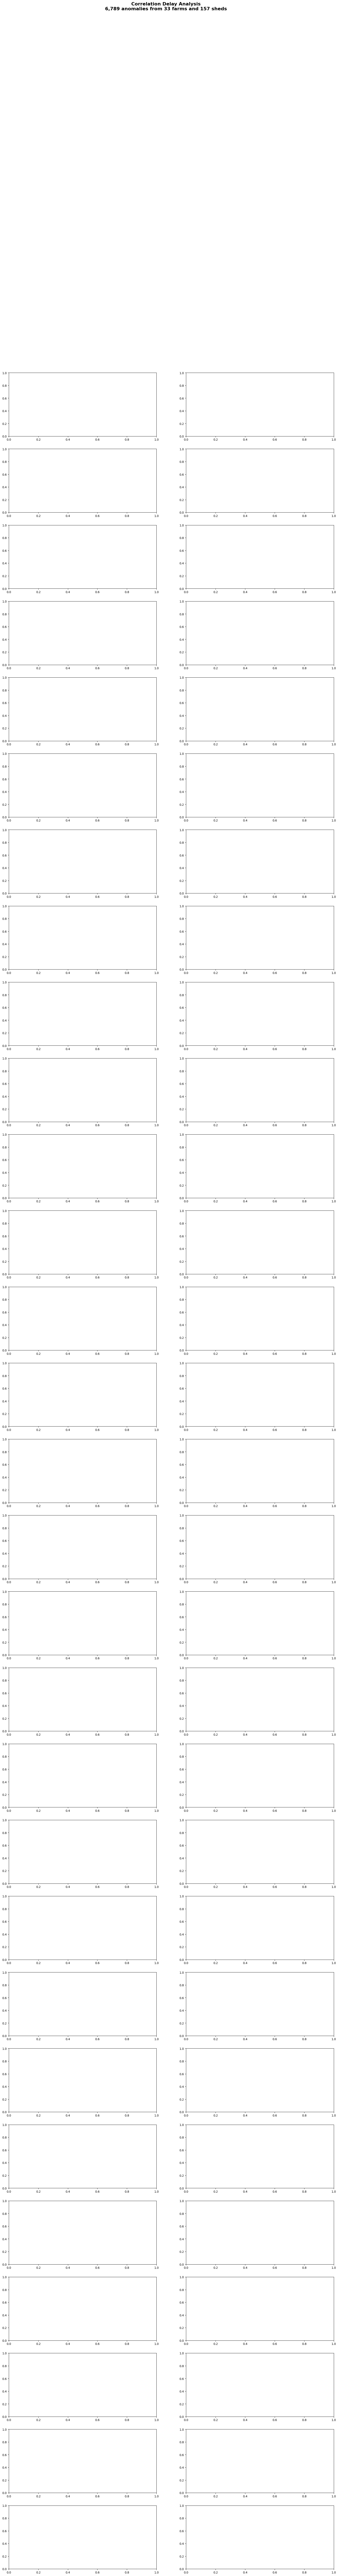

In [29]:
if RUN_HYPOTHESIS_1:
    # Alternative: with cumulative line
    plot(number_of_plots=number_of_plots, result=result, df=df, correlations=correlations_ordered, types=types, cumulative=False)


## Sub-hypothesis 2:
If we measure the time difference for all correlating factors of an anomaly, we would see how far back the same correlating factor occurs in other anomalies.

In [ ]:
RUN_HYPOTHESIS_2 = True

In [ ]:
def get_timedifferences(df: pd.DataFrame, anomalies: pd.DataFrame, max_lookback_length: int) -> pd.DataFrame:
    # Different approach: for each anomaly, only look at previous occurrences of its associated correlations
    # For each anomaly-correlation pair, find previous occurrences of that SAME correlation type

    # Start with the full dataset (each row is an anomaly-correlation pair)
    result_list = []

    for _, anomaly_row in anomalies.iterrows():
        shed_id = anomaly_row['ShedId']
        anomaly_id = anomaly_row['AnomalyId']
        anomaly_time = anomaly_row['LocalTime']
        
        # Get all correlations associated with this specific anomaly
        anomaly_correlations = df[(df['ShedId'] == shed_id) & (df['AnomalyId'] == anomaly_id)]['Correlation'].unique()
        
        # For each correlation type associated with this anomaly
        for corr_type in anomaly_correlations:
            # Find previous occurrences of this SAME correlation type in the same shed
            previous_same_corr = df[
                (df['ShedId'] == shed_id) & 
                (df['Correlation'] == corr_type) & 
                (df['LocalTime'] < anomaly_time)
            ]
            
            # Calculate time differences
            for _, prev_row in previous_same_corr.iterrows():
                delay_minutes = (anomaly_time - prev_row['LocalTime']).total_seconds() / 60
                
                # Only include if within lookback window
                if delay_minutes <= max_lookback_length * 60:
                    result_list.append({
                        'AnomalyId': anomaly_id,
                        'ShedId': shed_id,
                        'Correlation': corr_type,
                        'Delay': delay_minutes
                    })

    return  pd.DataFrame(result_list)

def get_timedifferences_per_category(df: pd.DataFrame, anomalies: pd.DataFrame, max_lookback_length: int) -> pd.DataFrame:
    # Different approach: for each anomaly, only look at previous occurrences of its associated correlations
    # For each anomaly-correlation pair, find previous occurrences of that SAME correlation type

    # Start with the full dataset (each row is an anomaly-correlation pair)
    result_list = []
    categories = anomalies['Category'].unique()
    assert len(categories) == 2

    for _, anomaly_row in anomalies.iterrows():
        shed_id = anomaly_row['ShedId']
        anomaly_id = anomaly_row['AnomalyId']
        anomaly_time = anomaly_row['LocalTime']
        category = anomaly_row['Category']
        
        # Get all correlations associated with this specific anomaly
        anomaly_correlations = df[(df['ShedId'] == shed_id) & (df['AnomalyId'] == anomaly_id) & (df['Category'] == category)]['Correlation'].unique()
        
        # For each correlation type associated with this anomaly
        for corr_type in anomaly_correlations:
            # Find previous occurrences of this SAME correlation type in the same shed
            previous_same_corr = df[
                (df['ShedId'] == shed_id) & 
                (df['Correlation'] == corr_type) & 
                (df['Category'] == category) &
                (df['LocalTime'] < anomaly_time)
            ]
            
            # Calculate time differences
            for _, prev_row in previous_same_corr.iterrows():
                delay_minutes = (anomaly_time - prev_row['LocalTime']).total_seconds() / 60
                
                # Only include if within lookback window
                if delay_minutes <= max_lookback_length * 60:
                    result_list.append({
                        'AnomalyId': anomaly_id,
                        'ShedId': shed_id,
                        'Correlation': corr_type,
                        'Category': category,
                        'Delay': delay_minutes
                    })

    return pd.DataFrame(result_list)


In [ ]:
if RUN_HYPOTHESIS_2:
    if PROCESS_BY_CATEGORY:
        result2 = get_timedifferences_per_category(df, anomalies, max_lookback_length)
            # Categorize and count
        result2['DelayInterval'] = pd.cut(result2['Delay'], bins=range(0, max_lookback_length*60+1, 15), labels=interval_labels, right=False)
        merged2 = result2.groupby(['Correlation', 'Category','DelayInterval']).size().reset_index(name='Count')
    else:
        result2 = get_timedifferences(df, anomalies, max_lookback_length)
        # Categorize and count
        result2['DelayInterval'] = pd.cut(result2['Delay'], bins=range(0, max_lookback_length*60+1, 15), labels=interval_labels, right=False)
        merged2 = result2.groupby(['Correlation', 'DelayInterval']).size().reset_index(name='Count')
    
    print(f"Sub-hypothesis 2: Found {len(result2)} correlation occurrences")

In [ ]:
if RUN_HYPOTHESIS_2:
    if PROCESS_BY_CATEGORY:
        types = determine_type_by_category(correlations=correlations_ordered, corr_data=result2)
    else:
        types = determine_type(correlations=correlations_ordered, corr_data=result2)

In [ ]:
if RUN_HYPOTHESIS_2:
    # Alternative: with cumulative line
    plot(number_of_plots=number_of_plots, result=merged2, df=df, correlations=correlations_ordered, types=types, cumulative=False)